# Analysis of AGN for PN Large Window Mode, no long-term CTI results



In [89]:
import os
import glob

import numpy as np

from astropy.table import Table, Column, vstack

%matplotlib inline

import matplotlib.pylab as plt
#from matplotlib.patches import Patch
#from matplotlib.lines import Line2D

import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
#
wdir = "/xdata/xcaldata/XMM/IVAN/PN_LW/sources"
os.chdir(wdir)

In [90]:
def read_cti_ccf(ccf_file,mode_id=2, energy_index=0):
    #
    # utility function to read the EPN CTI calfile and get the dat ain a dictionary
    #
    # mode_id = 0 for PRIME_FULL_WINDOW
    # mode_id = 1 for PRIME_FULL_WINDOW_EXTENDED
    # mode_id = 2 for PRIME_LARGE_WINDOW
    # mode_id = 3 for PRIME_SMALL_WINDOW
    #
    # energy_index = 0 is for Al Ka at 1.486
    # energy_index = 1 is for Mn Ka at 5.8988
    # energy_index = 2 is for Fe Ka at 6.4 keV
    #
    try:
        t = Table.read(f'{ccf_file}',hdu='LONG_TERM_CTI')
        tmp = Table.read(f'{ccf_file}',hdu='LTC_TIMES')
        #times = tmp.data['TIME'][0].flatten()                           
    except:
        print (f"Cannot read CCF file {ccf_file}, it must contain extension with name \"LONG_TERM_CTI\"")
        return None
    times = tmp['TIME'][0]
    tx = t.group_by('MODE_ID')
    mmask = tx.groups.keys['MODE_ID'] == mode_id
    tenergy = tx.groups[mmask].group_by('ENERGY')
    ixxx = np.arange(len(tenergy.groups))
    if (energy_index not in ixxx):
        print (f"The index for the energy {energy_index} is not available for this mode. Only indices: ", ixxx)
        return None
    grp = tenergy.groups[energy_index]
    #print (grp)
    tout = {}
    if (mode_id != 3):
        for iccd in np.arange(1,13):
            xmask = grp['CCD_ID'] == iccd
            tcoeff = grp[xmask]['T_COEFF']
            tout[iccd] = {'mode_id': mode_id, 'ccd': iccd, 'energy': grp['ENERGY'][0],
                'times': times, 'tcoeff': tcoeff[0]}
    else:
        tcoeff = grp['T_COEFF']
        tout[0] = {'mode_id': mode_id, 'ccd': 4, 'energy': grp['ENERGY'][0],
            'times': times, 'tcoeff': tcoeff[0]}
    return tout

In [176]:
# now read the current cal file 
#
# read the current long-term CCF.
#
ccfdir = '/ccf/pub'
#
# energy_index=0 is for Al Ka (1.486 keV)
# energy_index=1 is for Mn Ka (5.8988 keV)
# energy_index=2 is for Cu Ka (8.04 keV)
#
tmn = read_cti_ccf(f"{ccfdir}/EPN_CTI_0050.CCF",mode_id=2,energy_index=1)

tt = tmn[1]['times']
mean_rawy = 190 # for boresight/AGNs
tcoef4 = tmn[4]['tcoeff']
a0_x = tcoef4[0]
yy = np.power((1.0 - tcoef4)/(1.0 - tcoef4[0]),mean_rawy)
cti = {'x':tt,'y':yy}
a0_x

0.00043236

In [177]:
#
# define the targets and their redshift
#
targets = ["ngc3227","mkn1040","mkn915","ngc6814",'mkn883','tycho', 'ngc5899','ngc526a']
colors = {"ngc3227":'red',"mkn1040":'green',"mkn915":'blue',"ngc6814":'magenta','mkn883':'cyan','tycho': 'brown',
         'ngc5899': 'lime', 'ngc526a': 'orange'}
#
# redshifts
#
redshift = {'ngc4151': 0.003262, 'ngc3227': 0.00386, 'mrk1048': 0.0427, 'ngc3783': 0.009755,\
            'ngc4593': 0.008344, 'ngc5506': 0.00589, 'mcg-5-23-16': 0.008226, 'ngc3516': 0.008816,\
            'ngc5548': 0.01627, 'ngc2992':  0.007296, 'ngc1566': 0.005036, 'iras09149': 0.057150,\
            "iras05078": 0.017879, 'ngc7213': 0.005869,"mkn915": 0.024043,"mkn1040":0.016338,\
            "ngc6814": 0.005227, 'mkn883': 0.03787, 'tycho': 0.0, 'ngc5899': 0.00880, 'ngc526a': 0.01897}
feK = 6.399 # the weighted mean of Fe Kalpha_2 at 6.3908 (intensity 50) and Fe Kalpha_1 at 6.40308 (intensity 100)

Adding ngc3227
Adding mkn1040
Adding mkn915
Adding ngc6814
Adding mkn883
Adding tycho
Adding ngc5899
Adding ngc526a


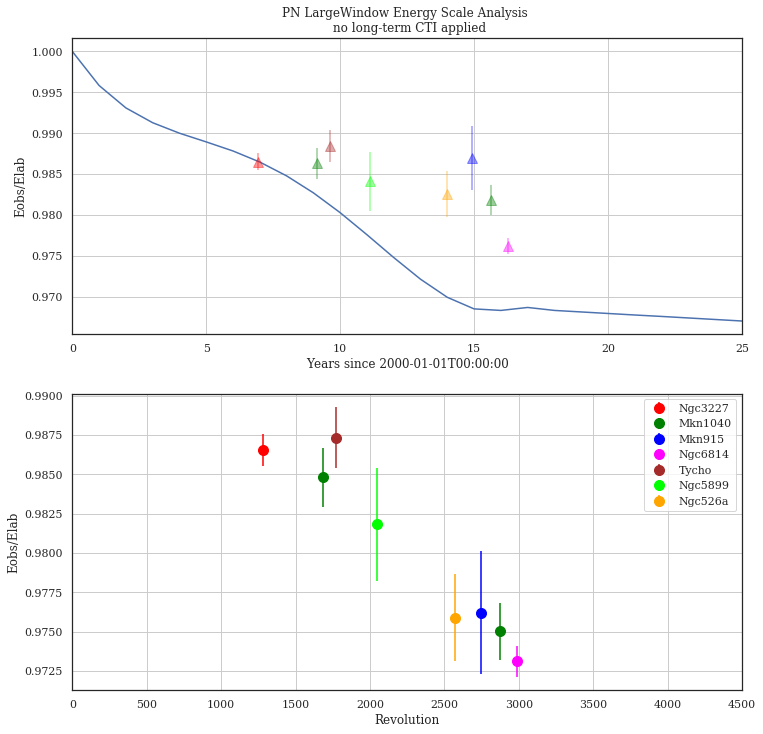

In [178]:
#
# calculate the differences and plot
# save some info in a tex table
#
xratio64 = []
xratio64err = []
xrtime = []
msize=10
xcols = {}
fig = plt.figure(figsize=(12,12))
(ax,ax2) = fig.subplots(2,1)
#vers = "cti48"
vers = "nocti"
k = 0
symb = 'o'
for target in targets:
    print (f"Adding {target}")
    # skip Mkn883
    if (target == 'mkn883'):
        continue
    out_tab = f'{target}_xspec_output_{vers}.csv'
    if (not os.path.isfile(out_tab)):
        print (f"No {vers} results found for target {target}: {out_tab}")
        continue
    t = Table.read(out_tab,data_start=0,names=("obsid","expo","rev","delta_time","submode",\
                                  "xfilt","inst","ontime",\
                                  "lineE","lineE_err","lineE_err2","cstat","chi2r","dof"))
    nt = len(t)
    #
    lineX =  feK/(1.0 + redshift[target]) # redshifted line position
    rev = t['rev'].data
    rtime = t['delta_time'].data
    xrtime = np.concatenate((xrtime,rtime))
    inst = t['inst'].data
    line = t['lineE'].data
    #lineErr = t['lineE_err'].data
    lineErr = t['lineE_err2'].data # use the fit error (single parameter)
    rchi2 = t["chi2r"].data
    diff = (line - lineX)*1000.0
    errs = [lineErr*1000,lineErr*1000.0]
    ratio = line/lineX
    ratio_err = [lineErr/lineX,lineErr/lineX]
    #
    # now extrapolate the ratio at 6.4 keV
    #
    # 1. get the ratio at 5.9 keV at the time of observation
    #
    y1 = np.interp(rtime,cti['x'],cti['y'])
    x1 = np.log(tmn[4]['energy']) # 5.8988
    y2 = ratio
    x2 = np.log(line)
    xnew = np.log(6.4) # keV
    #
    m = (y2-y1)/(x2-x1)
    ynew = m*(xnew - x2) + y2
    xratio64 = np.concatenate((xratio64,ynew))
    xratio64err = np.concatenate((xratio64err,lineErr/lineX))
    # the new ratio extrapolated to 6.4 keV
    #
    #ax.errorbar(rtime,ratio,yerr=(ratio_err),fmt=symb,color=colors[target],\
    #           markersize=msize,label=target.capitalize())
    ax.errorbar(rtime,ynew,yerr=(ratio_err),fmt='^',color=colors[target],\
               markersize=msize,label='',alpha=0.4)
    ax2.errorbar(rev,ratio,yerr=(ratio_err),fmt=symb,color=colors[target],\
               markersize=msize,label=target.capitalize())
    #
ax.plot(cti['x'],cti['y'])
ax.set_ylabel(r"Eobs/Elab")
ax.set_xlabel(r"Years since 2000-01-01T00:00:00")
ax.grid(True)
ax2.set_ylabel("Eobs/Elab")
ax2.set_xlabel("Revolution")
ax2.grid(True)
#ax.set_ylim([-40.0,60.0])
#ax2.set_ylim([-40.0,60.0])
ax.set_xlim([0.0,25.0])
ax2.set_xlim([0.0,4500.0])
#ax.set_title(f"PN SmallWindow Energy Scale Analysis\n Test #{ver}")
ax.set_title("PN LargeWindow Energy Scale Analysis \n no long-term CTI applied")
plt.legend(numpoints=1)
#plt.savefig('{}/pn_sw_cti49_results_control.png'.format(wdir),dpi=100)
#plt.savefig(f'{wdir}/pn_lw_cti48_cti49_results.png',dpi=100)
plt.show();
#plt.close()
#

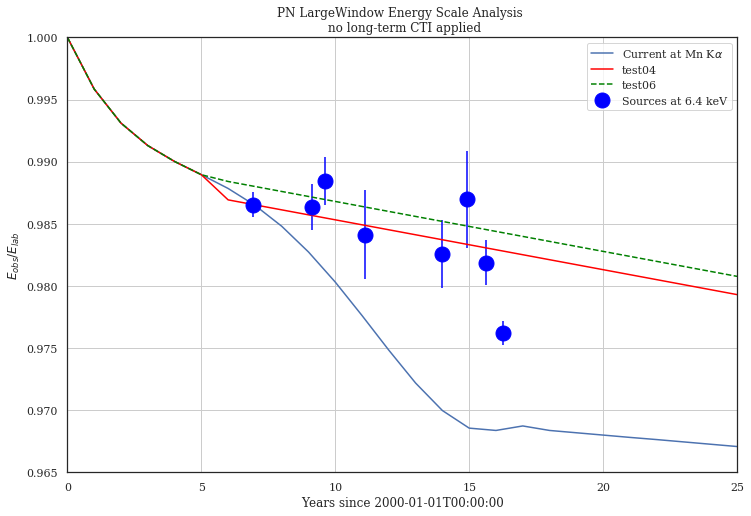

In [183]:
isort = np.argsort(xrtime)
xrtime = xrtime[isort]
xratio64 = xratio64[isort]
xratio64err = xratio64err[isort]
#
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
ax.errorbar(xrtime,xratio64,yerr=(xratio64err),fmt='o',color='blue',markersize=15,label='Sources at 6.4 keV')
weights = 1.0/xratio64err
# manually adjust some weights
weights[0] = 1.0e4
weights[-1] = 1.0
#
# now linear fit
#
z = np.polyfit(xrtime,xratio64,1,w=weights)
p = np.poly1d(z)
fitted = p(cti['x'])
#
fitted2 = fitted*1.0015 # test06
fitted[0:6] = cti['y'][0:6]
fitted2[0:6] = cti['y'][0:6]
#
ax.plot(cti['x'],cti['y'],label=r'Current at Mn K$\alpha$')
ax.plot(cti['x'],fitted,color='red',label='test04')
ax.plot(cti['x'],fitted2,color='green',linestyle='dashed',label='test06')
ax.set_ylabel(r"$E_{obs}/E_{lab}$")
ax.set_xlabel(r"Years since 2000-01-01T00:00:00")
ax.grid(True)
ax.legend()
ax.set_xlim([0.0,25.0])
ax.set_ylim([0.965,1.0])
ax.set_title("PN LargeWindow Energy Scale Analysis \n no long-term CTI applied")
#
plt.savefig(f'{wdir}/pnlw_agn_nocti_results_test06.png',dpi=100)
plt.show()
plt.close()

In [132]:
#
# calculate g(t) from the Eobs/Elab = fitted
#
gt2 = 1.0 - (1.0 - a0_x)*np.power(fitted2,1.0/190.0)
#gt2
gt2[0]

0.0004323721

## Build the new CCF

Will use the CCF with already improved PN_LW at Cu K$\alpha$ (8.04 keV) available in my `ccfdev` folder.

In [117]:
import time
from astropy.io import fits
today = time.strftime("%c")
#
ccfdir = '/xdata/xcaldata/XMM/IVAN/ccfdev'
# will use 0051.CCF_test01 
ccf_file = f"{ccfdir}/EPN_CTI_0051.CCF_test01"
hdu = fits.open(ccf_file)
ltc = hdu['LONG_TERM_CTI']
nrows = len(ltc.data)
#
xhdu = fits.BinTableHDU.from_columns(ltc.columns, nrows=nrows+1,name='LONG_TERM_CTI',header=ltc.header)
xhdu.data['MODE_ID'][nrows-1] = 2
xhdu.data['CCD_ID'][nrows-1] = 4
xhdu.data['ENERGY'][nrows-1] = 6.4
xhdu.data['T_COEFF'][nrows-1] = gt2
xhdu.data['SHIFT'][nrows-1] = 1
#
idx_sorted = np.lexsort((xhdu.data['ENERGY'],xhdu.data['CCD_ID'],xhdu.data['MODE_ID']))
xhdu.data = xhdu.data[idx_sorted]
xhdu.header.remove('HISTORY',remove_all=True)
xhdu.header.add_history(f'Created by Ivan V, {today}')
hdu['LONG_TERM_CTI'] = xhdu
hdu[0].header['FILENAME'] = "EPN_CTI_0051.CCF"
hdu.writeto(f"{ccfdir}/EPN_CTI_0051.CCF_test06",overwrite=True)
hdu.close()

In [118]:
# check
ccfdir = '/xdata/xcaldata/XMM/IVAN/ccfdev'
# will use 0051.CCF_test01 
t1 = read_cti_ccf(f"{ccfdir}/EPN_CTI_0051.CCF_test01",mode_id=2,energy_index=1)
tt = t1[1]['times']
mean_rawy = 190 # for boresight/AGNs
tcoef4 = t1[4]['tcoeff']
# now the new one
ccf_file = f"{ccfdir}/EPN_CTI_0051.CCF_test06"
hdu = fits.open(ccf_file)
ltc = hdu['LONG_TERM_CTI']
#
ix = np.where((ltc.data['MODE_ID'] == 2) & (ltc.data['CCD_ID'] == 4) & (ltc.data['ENERGY'] == 6.4))[0]
new_tcoef = ltc.data[ix]['T_COEFF'][0]

(0.0, 25.0)

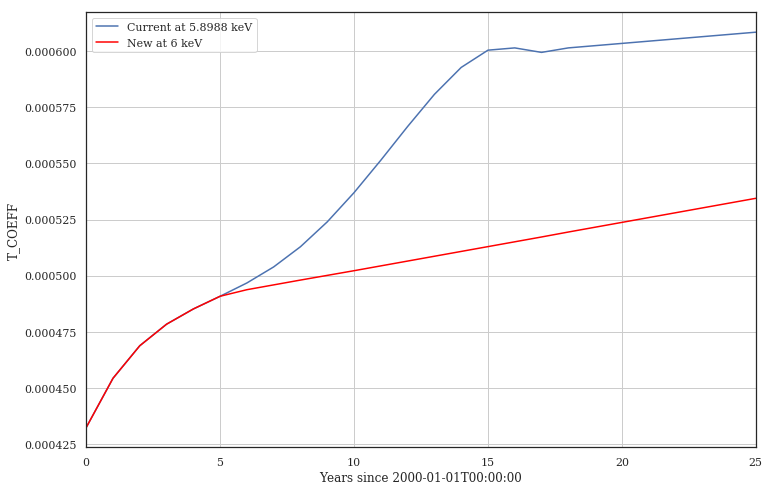

In [119]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
ax.plot(tt,tcoef4,label='Current at 5.8988 keV')
ax.plot(tt,new_tcoef,color='red',label='New at 6 keV')
ax.set_ylabel("T_COEFF")
ax.set_xlabel(r"Years since 2000-01-01T00:00:00")
ax.grid(True)
ax.legend()
ax.set_xlim([0.0,25.0])
#ax.set_ylim([0.97,1.0])
#ax.set_title("PN LargeWindow Energy Scale Analysis \n no long-term CTI applied")
#

## Check the results with the new CCF

Adding ngc3227
Adding mkn1040
Adding mkn915
Adding ngc6814
Adding mkn883
Adding tycho
Adding ngc5899
Adding ngc526a


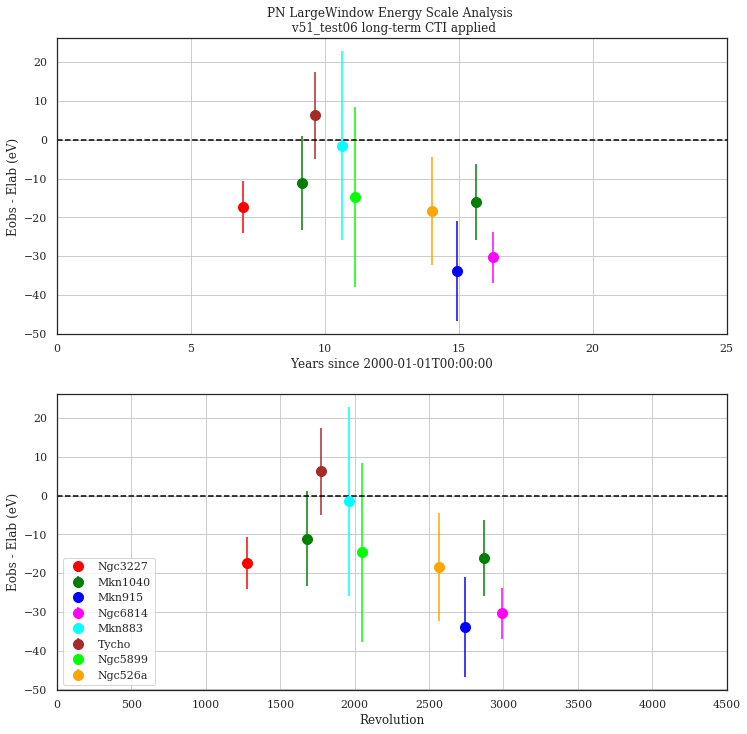

In [168]:
#
# calculate the differences and plot
# save some info in a tex table
#
xratio64 = []
xratio64err = []
xrtime = []
msize=10
xcols = {}
fig = plt.figure(figsize=(12,12))
(ax,ax2) = fig.subplots(2,1)
vers = "cti51x_08"
#vers = "cti48"
#vers = "nocti"
k = 0
symb = 'o'
for target in targets:
    print (f"Adding {target}")
    # skip Mkn883
    #if (target == 'mkn883'):
    #    continue
    out_tab = f'{target}_xspec_output_{vers}.csv'
    if (not os.path.isfile(out_tab)):
        print (f"No {vers} results found for target {target}: {out_tab}")
        continue
    t = Table.read(out_tab,data_start=0,names=("obsid","expo","rev","delta_time","submode",\
                                  "xfilt","inst","ontime",\
                                  "lineE","lineE_err","lineE_err2","cstat","chi2r","dof"))
    nt = len(t)
    #
    lineX =  feK/(1.0 + redshift[target]) # redshifted line position
    rev = t['rev'].data
    rtime = t['delta_time'].data
    xrtime = np.concatenate((xrtime,rtime))
    inst = t['inst'].data
    line = t['lineE'].data
    #lineErr = t['lineE_err'].data
    lineErr = t['lineE_err2'].data # use the fit error (single parameter)
    rchi2 = t["chi2r"].data
    diff = (line - lineX)*1000.0
    errs = [lineErr*1000,lineErr*1000.0]
    ratio = line/lineX
    ratio_err = [lineErr/lineX,lineErr/lineX]
    ax.errorbar(rtime,diff,yerr=(errs),fmt=symb,color=colors[target],\
              markersize=msize,label=target.capitalize())
    ax2.errorbar(rev,diff,yerr=(errs),fmt=symb,color=colors[target],\
              markersize=msize,label=target.capitalize())
    #
ax.axhline(0.0,color='black',linestyle='dashed')
ax.set_ylabel(r"Eobs - Elab (eV)")
ax.set_xlabel(r"Years since 2000-01-01T00:00:00")
ax.grid(True)
ax2.axhline(0.0,color='black',linestyle='dashed')
ax2.set_ylabel("Eobs - Elab (eV)")
ax2.set_xlabel("Revolution")
ax2.grid(True)
ax.set_xlim([0.0,25.0])
ax2.set_xlim([0.0,4500.0])
#ax.set_title(f"PN SmallWindow Energy Scale Analysis\n Test #{ver}")
ax.set_title("PN LargeWindow Energy Scale Analysis \n v51_test06 long-term CTI applied")
plt.legend(numpoints=1)
#plt.savefig(f'{wdir}/pnlw_agn_cti51_test07_results.png',dpi=100)
plt.savefig(f'{wdir}/pnlw_agn_cti51x_test08_results.png',dpi=100)
plt.show();
plt.close()
#

## Check the energy dependence at 1.48, 5.8988, 6.4 and 8 keV for CCD4

In [137]:
# check
ccfdir = '/xdata/xcaldata/XMM/IVAN/ccfdev'
# will use 0051.CCF_test01 
ccf_file = f"{ccfdir}/EPN_CTI_0051.CCF_test06"
hdu = fits.open(ccf_file)
ltc = hdu['LONG_TERM_CTI']
#
ix = np.where((ltc.data['MODE_ID'] == 2) & (ltc.data['CCD_ID'] == 4))[0]
lx = ltc.data[ix]

In [143]:
tcoef1 = lx['T_COEFF'][0,:]
tcoef5 = lx['T_COEFF'][1,:]
tcoef6 = lx['T_COEFF'][2,:]
tcoef8 = lx['T_COEFF'][3,:]

In [144]:
corr1 = np.power((1.0 - tcoef1)/(1.0 - tcoef1[0]),190)
corr2 = np.power((1.0 - tcoef5)/(1.0 - tcoef5[0]),190)
corr3 = np.power((1.0 - tcoef6)/(1.0 - tcoef6[0]),190)
corr4 = np.power((1.0 - tcoef8)/(1.0 - tcoef8[0]),190)

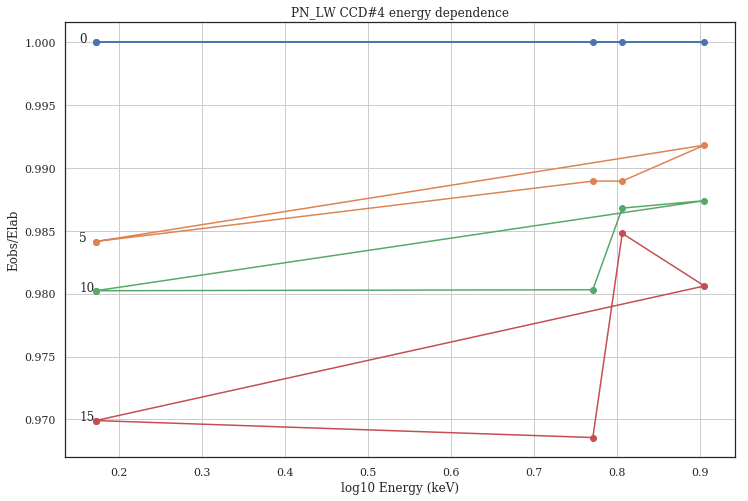

In [174]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
energies = np.array([1.486,5.8988,6.4,8.04,1.486])
for j in range(17):
    if (j % 5 == 0):
        #ax.semilogx(energies,[corr1[j],corr2[j],corr3[j],corr4[j]],'o-')
        ax.plot(np.log10(energies),[corr1[j],corr2[j],corr3[j],corr4[j],corr1[j]],'o-')
        ax.text(np.log10(1.42),corr1[j],j)
ax.set_title("PN_LW CCD#4 energy dependence")
ax.set_ylabel("Eobs/Elab")
ax.set_xlabel(r"log10 Energy (keV)")
ax.grid(True)
#ax.legend()
#plt.savefig(f'{wdir}/pnlw_energy_test06.png',dpi=100)
plt.show();
plt.close()


In [146]:
lx

FITS_rec([(2, 4, 1.486 , [0.0007134 , 0.00075229, 0.00077612, 0.00078921, 0.00079527, 0.00079744, 0.00079826, 0.0007997 , 0.00080312, 0.0008093 , 0.00081844, 0.00083014, 0.00084343, 0.00085672, 0.00086787, 0.00087412, 0.00087215, 0.00085802, 0.00085802, 0.00085802, 0.00085802, 0.00085802, 0.00085802, 0.00085802, 0.00085802, 0.00085802], 1.),
          (2, 4, 5.8988, [0.00043236, 0.00045428, 0.0004688 , 0.0004784 , 0.00048518, 0.00049085, 0.00049677, 0.00050392, 0.00051291, 0.00052398, 0.000537  , 0.00055145, 0.00056646, 0.00058078, 0.00059278, 0.00060047, 0.00060148, 0.00059948, 0.00060148, 0.00060248, 0.00060348, 0.00060448, 0.00060548, 0.00060648, 0.00060748, 0.00060848], 1.),
          (2, 4, 6.4   , [0.00043237, 0.00045431, 0.00046879, 0.00047839, 0.00048518, 0.00049084, 0.00049376, 0.00049591, 0.00049806, 0.00050014, 0.00050223, 0.00050437, 0.00050652, 0.00050867, 0.00051081, 0.00051296, 0.0005151 , 0.00051725, 0.00051945, 0.0005216 , 0.00052375, 0.00052589, 0.00052804, 0.00053018